<h2> Project SAP - Analyzing deforestation rates in South America </h2>
<h3> Team members: Anuj Verma(112504481), Priyanka Bedarkar(112046765) and Saif Vazir(112072061) </h3>
<h4> General Description of Code </h4>
<ul>
    <li>Create RDD of Forest Gain images and calculate total forest gain from 2000-2012</li>
    <li>Create RDD of Forest Loss images and calculate total forest loss for each year from 2012-2018</li>
    <li>Split images into smaller tiles for analysis at a finer granularity</li>
    <li>Generate forest change maps for smaller tiles</li> 
    <li>Use smaller tiles to pass through CNN and extract features</li>
    <li>Use kmeans clustering on these features and find the correct number of clusters by analyzing through elbow method</li>
    <li>Use hand-crafted features and apply kmeans clustering, find correct number of clusters by analyzing through elbow method</li>
    <li>Use regression to find correlation between latitude,longitude and deforestation. Use regression model to predict deforestation rates given latitude and longitude as inputs.</li>
</ul>
<h4> Cluster configuration </h4>
<ul>
    <li>Used Google Cloud Platform</li>
    <li>Google Dataproc running Debian 9, Spark 2.3, Hadoop 2.9.2, Python 2.7
    <li>Config: 1 Leader, 4 workers </li>
    <li>Each node has 26GB RAM(n1-highmem)</li>
    <li>Disk space used is 100GB for master node and 30GB for each worker node</li>
    <li>Install Opencv, Pytorch, PIL on all nodes</li>
    <li>Change MAX_IMAGE_PIXELS in Image.py(in PIL package) to (16384*16384*16384)</li>
</ul>
<h4> Spark Configuration </h4>
<ul>
    <li>Spark config in program
        <ul>
            <li>spark.executor.memory set as 17GB</li>
            <li>spark.yarn.executor.memoryOverhead set as 3GB</li>
        </ul>
    </li>
    <li>Changes in spark-default.conf
        <ul>
            <li>spark.driver.memory set as 15GB</li>
            <li>spark.memory.offHeap.enabled set as true</li>
            <li>spark.memory.offHeap.size set as 8GB</li>
            <li>spark.driver.maxResultSize set as 8GB</li>
            <li>spark.sql.shuffle.partitions set as 1000</li>
            <li>spark.storage.memoryFraction set as 0.1</li>
        </ul>
    </li>
</ul>

In [308]:
### Import packages ######
from pyspark import SparkConf, SparkContext
import numpy as np
from glob import glob
import os
from PIL import Image
import io

<h2>Setting spark configuration</h2>

In [309]:
# sc.stop()
conf = SparkConf()
conf.set("spark.executor.memory",'17g')
# conf.set('spark.driver.memory','8g')
# conf.set('spark.memory.offHeap.enabled','true')
# conf.set('spark.memory.offHeap.size','15g')
# conf.set('spark.cores.max','5')
# conf.set('spark.driver.maxResultSize','8g')
# conf.set('spark.sql.shuffle.partitions','1000')
# conf.set('spark.storage.memoryFraction','0.1')
conf.set('spark.yarn.executor.memoryOverhead','3g')
sc = SparkContext(conf=conf)

<h2>Create RDD of Forest Gain Images</h2>

In [310]:
rdd = sc.binaryFiles("hdfs://proj-working-m:8020/user/saif/gain/")

<h2> Map function for Gain images </h2>
<p>Counts the total forest gain in a particular image. Each image cover 10x10degrees in the world map.<br>
   Images have values 0's for no forest and 1's for forest gain. These outputs constitute a part of our final results
to report the total forest gain in all of South America from 2000-2012 </p>
<h3> Pipeline used:</h3>
<ul>
    <li>Spark</li>
    <li>Hadoop(HDFS)</li>
</ul>

In [311]:
def mapper_func(x):
    name = x[0]
    img = Image.open(io.BytesIO(x[1]))###Read image from byte array
    img = np.asarray(img,dtype=np.uint8)
    total_gain = np.sum(img)
    return (name,total_gain)


In [312]:
####Collect forest gain results and print 1 ######
res = rdd.map(mapper_func).collect()
print(res[0])

(u'hdfs://proj-working-m:8020/user/saif/gain/Hansen_GFC-2016-v1.4_gain_00N_050W.tif', 12098464)


<h2> Save gain results for evaluation and other tasks </h2>

In [313]:
f = open("/home/saifsuleman_vazir/gain_results_new.txt","w")
for i in range(60):
    f.write(str(res[i][0])+","+str(res[i][1])+"\n")
for i in range(60,len(res)):
    f.write(str(res[i][0])+","+str(res[i][1])+"\n")
f.close()

<h2> Map function for Loss images </h2>
<p> Loss images have values of different years from 0-respective year when image was taken, which represents the year in which loss/deforestation took place in that area.<br>
    We find the total number of pixels having that years value, which gives us total deforestation for a particular
    10x10 degrees region.</p>
<h3> Pipeline used:</h3>
<ul>
    <li>Spark</li>
    <li>Hadoop(HDFS)</li>
</ul>

In [314]:
def loss_mapper_func(x):
    name = x[0]
    img = Image.open(io.BytesIO(x[1]))
    img = np.asarray(img,dtype=np.uint8)
    year = 0
    if "-" in name.split("_")[1]:
        year = int(name.split("_")[1].split("-")[1][-2:])
    else:
        year = int(name.split("_")[1][-2:])-1
    ####Loss year images have year number as pixel values, hence find all pixels with that particular year####
    ####This will give total deforestation in that year####
    t = np.argwhere(img==year)
    return (name,t.shape[0])
    
    

In [319]:
loss_rdd = sc.binaryFiles("hdfs://proj-working-m:8020/user/saif/loss/*.tif")

In [320]:
####Collect loss results####
loss_res = loss_rdd.map(loss_mapper_func).collect()
print(len(loss_res))

126


In [321]:
loss_res[0]

(u'hdfs://proj-working-m:8020/user/saif/loss/Hansen_GFC-2016-v1.4_lossyear_10N_080W.tif',
 4647232)

<h2> Check if values are read properly from HDFS in bytes</h2>

In [322]:
def check_no_garbage(x):
    name = x[0]
    img = Image.open(io.BytesIO(x[1]))
    img = np.asarray(img,dtype=np.uint8)
    u = np.unique(img)
    return (name,u)

In [64]:
rdd_trial = sc.binaryFiles("hdfs://proj-working-m:8020/user/saif/temp/").map(check_no_garbage).take(10)
print(rdd_trial)

[(u'hdfs://proj-working-m:8020/user/saif/temp/9.9S-30.1W.tif', array([0], dtype=uint8)), (u'hdfs://proj-working-m:8020/user/saif/temp/9.9S-30.2W.tif', array([0], dtype=uint8)), (u'hdfs://proj-working-m:8020/user/saif/temp/9.9S-30.3W.tif', array([0], dtype=uint8)), (u'hdfs://proj-working-m:8020/user/saif/temp/9.9S-30.4W.tif', array([0], dtype=uint8)), (u'hdfs://proj-working-m:8020/user/saif/temp/9.9S-30.5W.tif', array([0], dtype=uint8)), (u'hdfs://proj-working-m:8020/user/saif/temp/9.9S-30.6W.tif', array([0], dtype=uint8)), (u'hdfs://proj-working-m:8020/user/saif/temp/9.9S-30.7W.tif', array([0], dtype=uint8)), (u'hdfs://proj-working-m:8020/user/saif/temp/9.9S-30.8W.tif', array([0], dtype=uint8)), (u'hdfs://proj-working-m:8020/user/saif/temp/9.9S-30.9W.tif', array([0], dtype=uint8)), (u'hdfs://proj-working-m:8020/user/saif/temp/9.9S-31.0W.tif', array([0], dtype=uint8))]


<h2> Save loss/deforestation results for further analysis </h2>

In [26]:
f1 = open("/home/saifsuleman_vazir/loss_results_new.txt","w")
for i in range(60):
    f1.write(str(loss_res[i][0])+","+str(loss_res[i][1])+"\n")
for i in range(60,len(loss_res)):
    f1.write(str(loss_res[i][0])+","+str(loss_res[i][1])+"\n")
f1.close()

<h2> Loss only for year 2015</h2>
<p>This function calculates loss for 2015 from 2016 images as data for the year 2015 and 2016 is different due
to version change at the source. These losses constitute a part of our results to measure total deforestation in a particular year. </p>
<h3> Pipeline used:</h3>
<ul>
    <li>Spark</li>
    <li>Hadoop(HDFS)</li>
</ul>

In [7]:
def loss_mapper_func_2015(x):
    name = x[0]
    img = Image.open(io.BytesIO(x[1]))
    img = np.asarray(img,dtype=np.uint8)
    year = 0
    if "-" in name.split("_")[1]:
        year = int(name.split("_")[1].split("-")[1][-2:])-1
    else:
        year = int(name.split("_")[1][-2:])-1
    t = np.argwhere(img==year)
    return (name,t.shape[0])

In [31]:
rdd_2016 = sc.binaryFiles("hdfs://proj-working-m:8020/user/saif/loss/only2016/").map(loss_mapper_func_2015).collect()
print(len(rdd_2016))

21


In [32]:
f2 = open("/home/saifsuleman_vazir/loss_results_2015.txt","w")
for i in range(len(rdd_2016)):
    f2.write(str(rdd_2016[i][0])+","+str(rdd_2016[i][1])+"\n")
f2.close()

<h2> Split images into smaller tiles </h2>
<p> This map function will split each 40000x40000 image into 400x400 tiles. This is required so that finer granularity analysis can take place. Also, we will pass these smaller images through a deep learning model to get the respective features for clustering.</p>
<h3> Pipeline used:</h3>
<ul>
    <li>Spark</li>
    <li>Hadoop(HDFS)</li>
</ul>

In [324]:
def split_images(x):
    name = x[0]
    img = Image.open(io.BytesIO(x[1]))
    img = np.asarray(img,dtype=np.uint8)
    new_size = 400
    factor = int(img.shape[0]/new_size)
    w = np.split(img, factor, 1)
    y1 = np.array(w)
    w1 = np.split(y1, factor, 1)
    y = np.array(w1)
    ###Create 10000x400x400 matrix, each tile is 400x400 and we have 10000 such tiles per image of 40K x 40K####
    z = y.reshape([y.shape[0]*y.shape[1]]+list(y.shape[2:]))
    ###Diff is number of degrees changed per small tile####
    diff = 0.1
    result = list()
    split_fname = name.split('_')
    lng = float(split_fname[-1].split('.tif')[0][:-1])
    e_w = 1 if split_fname[-1].split('.tif')[0][-1]=='E' else -1
    lat = float(split_fname[-2][:-1])
    n_s = 1 if split_fname[-2][-1]=='S' else -1
    year = 0
    if "-" in name.split("_")[1]:
        year = int(name.split("_")[1].split("-")[1][-2:])
    else:
        year = int(name.split("_")[1][-2:])-1
    
    if "treecover" in name:
        flag = "0"
    elif "loss" in name:
        flag = "1"
    elif "gain" in name:
        flag = "2"
    else:
        flag = "3"
    complement_dirn = { 'S': 'N', 'N': 'S', 'E': 'W', 'W': 'E'}
    
    ##### Create key value pairs with key as latitude longitude, value as year, smaller tiles and flag#####
    
    for i, arr in enumerate(z):
        latitude = (lat+n_s*(i%y.shape[0]) * diff)
        longitude = (lng+e_w*(i//y.shape[0]) * diff)
        dirn_lng = split_fname[-1].split('.tif')[0][-1]
        dirn_lat = split_fname[-2][-1]
        if latitude<0:
            latitude = -1*latitude
            dirn_lat = complement_dirn[dirn_lat]
        if longitude<0:
            longitude = -1*longitude
            dirn_lng = complement_dirn[dirn_lng]
        my_key = str(latitude)+dirn_lat+'-'+str(longitude)+dirn_lng+".tif"
        ###### Handle case for missing 15 data at source #######
        if year == 16:
            key_for_15 = str(latitude)+dirn_lat+'-'+str(longitude)+dirn_lng+".tif"
            result.append((key_for_15, (year-1,arr,flag)))
        result.append((my_key,(year, arr, flag))) 
    return result
    

<h3> Map function to calculate loss in smaller regions </h3>

In [325]:
def sum_split_images(vs):
    t = np.argwhere(list(vs[1])[1]==int(vs[1][0]))
    return (vs[0],len(t))

In [326]:
rdd_split_test = sc.binaryFiles("hdfs://proj-working-m:8020/user/saif/loss/only2018/").flatMap(split_images)

<h2> Plot some small tiles as forest change map </h2>
<p>Treecover is represented as green pixels, deforestation is represented by red pixels. Black pixels represent no forest cover in that area. These maps constitute a part of our results.</p>
<h3> Pipeline used:</h3>
<ul>
    <li>Spark</li>
    <li>Hadoop(HDFS)</li>
</ul>

In [327]:
%matplotlib inline

In [328]:
import matplotlib.pyplot as plt

In [329]:
####Split loss images into smaller images ####
rdd_treecover = sc.binaryFiles("hdfs://proj-working-m:8020/user/saif/temp/").flatMap(split_images)#.map(lambda x:(x[0].split("/")[-1],x[1]))

In [330]:
####Join treecover rdd with loss rdd using name of image as key #######
rdd_all = rdd_treecover.join(rdd_split_test)

In [331]:
def forest_map(x):
    k = x[0]
    treecover_img = x[1][0][1]
    year = x[1][1][0]
    arr = x[1][1][1]
    flag = x[1][1][2]
#     color = [0,0,0]
    forest_change_map = np.zeros((treecover_img.shape[0],treecover_img.shape[1],3),dtype=np.uint8)
    green_idx = np.argwhere(treecover_img!=0)
    for each in green_idx:
        forest_change_map[each[0],each[1]] = [0,255,0]
    if flag == "1":
#         color = [0,0,255]           #Color loss pixels as red
        red_idx = np.argwhere(arr==year)
        for each in red_idx:
            forest_change_map[each[0],each[1]] = [255,0,0]
    else:
#         color = [255,0,0]          #Color gain as blue
        blue_idx = np.argwhere(arr==1)
        for each in blue_idx:
            forest_change_map[each[0],each[1]] = [0,0,255]
    
    return (k,forest_change_map)

In [332]:
fc_maps = rdd_all.map(forest_map).take(5)

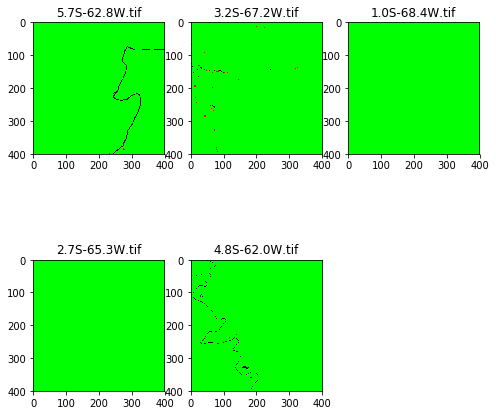

In [333]:
w=10
h=10
fig=plt.figure(figsize=(8, 8))
columns = 3
rows = 2
for i in range(1, columns*rows):
    img = fc_maps[i-1][1]
    fig.add_subplot(rows, columns, i)
    plt.title(fc_maps[i-1][0])
    plt.imshow(img)
plt.show()
#####Green pixels show tree cover, red pixels show deforestation and black pixels represent no forest cover#####

<h2> Feature extraction using Alexnet </h2>
<p> Use Pretrained Alexnet as a feature extractor on the images. Then pass these features for clustering using k-means clustering method. </p>
<h3> Pipeline used:</h3>
<ul>
    <li>Spark</li>
    <li>Hadoop(HDFS)</li>
    <li>Pytorch</li>
</ul>
<h3> Concepts used:</h3>
<ul>
    <li>Neural networks</li>
    <li>K-Means clustering</li>
    <li>Data Parallelism</li>
</ul>

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
import time
import copy
import cv2

In [17]:
####Get pretrained Alexnet model####
model_ft = models.alexnet(pretrained=True)

In [18]:
###Remove last FC layer####
new_classifier = nn.Sequential(*list(model_ft.classifier.children())[:-1])
model_ft.classifier = new_classifier
global model_bc
####Broadcast entire model to all nodes###
model_bc = sc.broadcast(model_ft)

In [19]:
model_bc.value

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p

In [23]:
def feature_extractor(x):
    k = x[0]
    year = x[1][0]
    arr = x[1][1]
    new_mat = np.zeros(arr.shape,dtype=np.uint8)
    scaler = transforms.Scale((224, 224))
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
    to_tensor = transforms.ToTensor()
    t = np.argwhere(arr==year)
    for each in t:
        new_mat[each[0],each[1]] = 255
    inputs = np.zeros((new_mat.shape[0],new_mat.shape[1],3),dtype=np.uint8)
    inputs[:,:,0] = new_mat
    inputs[:,:,1] = new_mat
    inputs[:,:,2] = new_mat
    img = Image.fromarray(inputs)
    ####Create input variable from above matrix ######
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    (model_bc.value).eval()
    op = (model_bc.value)(t_img)
    op = op.detach().numpy()
    #####Return name as key and output as 4096 vector#####
    return (k,(year,op))

In [24]:
###Gather features into csv###
feats = rdd_split_test.map(feature_extractor).take(1000)

In [84]:
####Sanity check to see if no nans present####
np.isnan(feats[0][1][1])

array([[False, False, False, ..., False, False, False]])

In [290]:
###Create matrix for clustering####
X = np.zeros((1,4096))
for each in feats:
    X = np.vstack((X,each[1][1]))
X = X[1:,:]

In [291]:
####Remove columns with all 0s###
X = X.T
X = X[~np.all(X == 0, axis=1)]
X.shape

(364, 1000)

In [292]:
####Re-transform to original shape###
X_new = X.T
X_new.shape

(1000, 364)

In [297]:
X_new

array([[0.05835306, 0.90425146, 2.0337801 , ..., 0.09727066, 1.46044004,
        0.28487837],
       [0.05835306, 0.90425146, 2.0337801 , ..., 0.09727066, 1.46044004,
        0.28487837],
       [0.05835306, 0.90425146, 2.0337801 , ..., 0.09727066, 1.46044004,
        0.28487837],
       ...,
       [0.05835306, 0.90425146, 2.0337801 , ..., 0.09727066, 1.46044004,
        0.28487837],
       [0.05835306, 0.90425146, 2.0337801 , ..., 0.09727066, 1.46044004,
        0.28487837],
       [0.05835306, 0.90425146, 2.0337801 , ..., 0.09727066, 1.46044004,
        0.28487837]])

In [293]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [295]:
###Perform clustering for different values of k####
sse2_cnn = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k,random_state=0).fit(X_new)
    sse2_cnn.append(sum(np.min(cdist(X_new, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X_new.shape[0])
    print k, sse2_cnn[-1]
###All values of tiles are same, therefore sum of squared errors is 0####

1 0.0
2 0.0
3 0.0
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0


<h2> Conclusion from above clustering experiment </h2>
<p> As was suggested by the Professor in the feedback, CNN cannot perform well as a feature extractor in our case as the maps are binary (black/white) and have no distinguishable features in a small tile (400x400). This method can be applicable at a larger scale where bigger images can have more distinguishable features in terms of shapes/boundaries. But our current configuration prohibits us to follow this direction as the large image (40Kx40K) will not fit into main memory. Therefore, we will use hand-crafted features to perform clustering and see its performance.</p>  

<h2> Use hand-crafted features for clustering and KNN to find nearest neighbours in that cluster </h2>

In [335]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from collections import Counter
from random import shuffle
from scipy.spatial import distance

In [336]:
###Function to calculate featurs as latitude,longitude,year and cumulative loss####
def data_for_cluster(x):
    name = x[0]
    img = x[1][1]
    new_size = 400
    factor = int(img.shape[0]/new_size)
    w = np.split(img, factor, 1)
    y1 = np.array(w)
    w1 = np.split(y1, factor, 1)
    y = np.array(w1)
    z = y.reshape([y.shape[0]*y.shape[1]]+list(y.shape[2:]))
    
    diff = 0.1
    result = list()
    split_fname = name.split('-')
    lng = float(split_fname[-1].split('.tif')[0][:-1])
    e_w = 1 if split_fname[-1].split('.tif')[0][-1]=='E' else -1
    lat = float(split_fname[-2][:-1])
    n_s = 1 if split_fname[-2][-1]=='S' else -1
    year = x[1][0]
    
    ##### For each small tile, add list of [lat,long,year,loss] to array #####
    
    for i, arr in enumerate(z):
        latitude = (lat+n_s*(i//y.shape[0]) * diff)
        longitude = (lng+e_w*(i%y.shape[0]) * diff)
        ###### Handle case for missing 15 data at source #######
        if year == 16:
            tmp = []
            tmp.append(latitude)
            tmp.append(longitude)
            tmp.append(year-1)
            tmp.append(len(np.argwhere(arr == year-1)))
            result.append(tmp)
        tmp=[]
        tmp.append(latitude)
        tmp.append(longitude)
        tmp.append(year)
        tmp.append(len(np.argwhere(arr == year)))
        result.append(tmp)
    return result

In [337]:
#####Gather hand crafted features in format (latitude,longitude,year, loss/deforestation) #######
hand_crafted_features = rdd_split_test.flatMap(data_for_cluster).collect()

In [338]:
####Sanity check to confirm that there are non-zero loss values####
x = [a[3] for a in hand_crafted_features]
x = np.array(x)
np.count_nonzero(x)

87642

In [339]:
####Scale data before clustering#####
scaler = StandardScaler()
hand_crafted_features = np.array(hand_crafted_features)
transformed_data = scaler.fit_transform(hand_crafted_features)
print transformed_data.shape

(210000, 4)


In [340]:
####Perform kmeans clustering with different cluster sizes to find intrinsic clusters in the data######
sse1 = []
sse2 = []
xval = []

for i in range(1, 16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(transformed_data)
    sse1.append(kmeans.inertia_)
    sse2.append(sum(np.min(cdist(transformed_data, kmeans.cluster_centers_, 'euclidean'), axis=1)) / transformed_data.shape[0])
    xval.append(i)
    print i, sse2[-1]

1 1.445044695913964
2 1.1153481212324254
3 0.894020269237274
4 0.8259989544836764
5 0.7926578572058556
6 0.7050681388396768
7 0.637305707264488
8 0.6242005369999865
9 0.5801433979423454
10 0.5688523991468857
11 0.5390639279960279
12 0.5108770838573834
13 0.48082752167438864
14 0.4693561241495024
15 0.4470831240286841


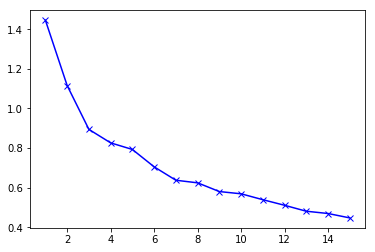

In [341]:
###Plot sum of squared distance in clusters versus number of clusters#####
plt.plot(xval, sse2, 'bx-')
plt.show()

<h2> Elbow method </h2>
<p> In the above plot we can visually see that the number of intrinsic clusters is 3 by following the elbow method. Therefore we will perform clustering with 3 clusters and find the nearest neighbours of some data points in these clusters. We can then visually inspect if the results are satisfactory. Further offline analysis can be done using the geographic location of the tiles to see that a particular area/region might be affected by more deforestation/loss and find the reason behind it.</p> 

In [342]:
kmeans = KMeans(n_clusters=3, random_state=0).fit(transformed_data)

In [343]:
###Uniform clusters formed###
lab = np.array(kmeans.labels_)
Counter(lab)

Counter({0: 73867, 1: 71423, 2: 64710})

In [344]:
####Get 50 random data points for each cluster### 
dic = {}
for cid in range(3):
    idx = np.argwhere(lab==cid).flatten()
    shuffle(idx)

    my_idx = idx[:50]
    xval = []
    yval = []
    for x in my_idx:
        yval.append(hand_crafted_features[x, 0]) # lat
        xval.append(hand_crafted_features[x, 1]) # lng
    dic[cid]=[xval, yval]

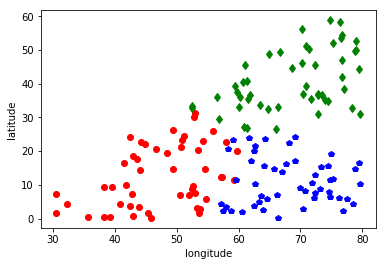

In [345]:
####Plot cluster points to visualize results###
marker = ['ro','bp','gd']
for cid, val in dic.items():
    plt.plot(val[0], val[1], marker[cid])
    plt.xlabel("longitude")
    plt.ylabel("latitude")
plt.show()

<h2>Conclusions from the above plots</h2>
<p>After clustering the hand-crafted features for loss/deforestation over the year 2018, we can observe that the clusters are  well defined and isolated. The x-axis represents the longitude(30W-80W) and the y-axis represents the latitude(00N-60S). We can infer that forests lying between latitude 00N-30S and longitude 30W-60W have the same kind of deforestation. Similarly, forests of region (30S-60S,55W-80W) have similar deforestation and forests of region (00N-25S,60W-80W) have similar deforestation. These results can help us target specific regions with specific activites to curb deforestation. </p>

<h2> Nearest Neighbours </h2>
<p> Find the nearest neighbours of a sample datapoint and visually inspect the forest map to check the similarity of these forest areas/regions in terms of deforestation. </p>
<h3> Concepts used:</h3>
<ul>
    <li>Nearest Neighbours</li>
</ul>

In [304]:
####Take cluster 2 and find nearest neighbours of a particular point in this cluster#####
cid = 2
idx = np.argwhere(lab==cid).flatten()
point = idx[0]
print point
dic = {}
for x in idx:
    dic[x] = distance.euclidean(hand_crafted_features[x], hand_crafted_features[point])

closest_points = sorted(dic, key=dic.get)[-5:]
print closest_points

3
[32708, 51371, 53144, 15964, 50067]


In [305]:
####Results to see that a some regions have similar deforestation rates#####
cp = hand_crafted_features[closest_points]
print(cp)
###Below result is of the format [Latitude,Longitude,Year,Loss]

[[8.0000e-01 4.7300e+01 1.8000e+01 3.5896e+04]
 [1.7100e+01 4.8700e+01 1.8000e+01 3.8685e+04]
 [1.4400e+01 4.6900e+01 1.8000e+01 4.0193e+04]
 [6.4000e+00 5.4100e+01 1.8000e+01 4.6276e+04]
 [1.6700e+01 5.0000e+01 1.8000e+01 7.5632e+04]]


In [306]:
###Function to filter tiles from rdd based on key value, then visualize these tiles ####
def show_image_tile(point, rdd_split_test):
    try:
        lat, lng, year, loss = point
        year = int(year)
        print lat, lng, year
        n_s = "S"
        e_w = "W"
        if lat<0:
            lat = str(-1*lat)
            n_s = "N"
        this_key=(str(lat)+n_s+"-"+str(lng)+e_w+".tif")
        print this_key
        img = rdd_split_test.filter(lambda x: (x[0]==this_key and x[1][0]==year)).first()[1][1]
        red_idx = np.argwhere(img==year)
        disp_img = np.zeros((img.shape[0],img.shape[1],3),dtype=np.uint8)
        for each in red_idx:
            disp_img[each[0],each[1]] = [255,0,0]
        plt.imshow(disp_img)
        plt.title((this_key, year))
        plt.show()
    except ValueError:
        return

0.8 47.3 18
0.8S-47.3W.tif


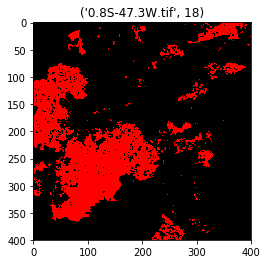

17.1 48.7 18
17.1S-48.7W.tif


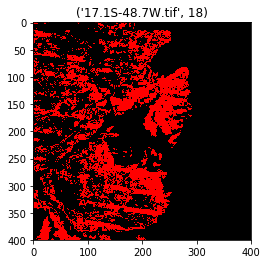

14.4 46.9 18
14.4S-46.9W.tif


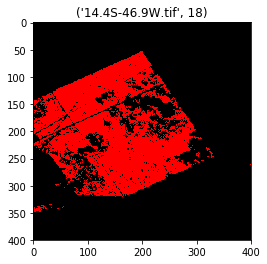

6.4 54.1 18
6.4S-54.1W.tif


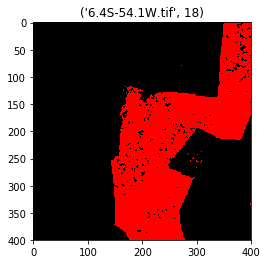

16.7 50.0 18
16.7S-50.0W.tif


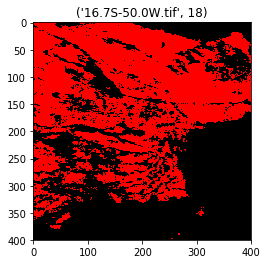

In [307]:
for p in cp:
    show_image_tile(p,rdd_split_test)
####Red pixels denote deforestation activities carried out in 2018 in a particular area###

<h2> Linear regression </h2>
<p> We will now try to predict the deforestation/loss by using multivariate regression. We have the label(predictor variable) as the loss, whereas the features(independent variables) will be latitude,longitude,year. Looking at the weights(correlation factors) of every feature will also give us insights regarding which features really affect the deforestation. <p>
<h3> Concepts used:</h3>
<ul>
    <li>Regression</li>
</ul>

In [218]:
rdd_split_2017 = sc.binaryFiles("hdfs://proj-working-m:8020/user/saif/loss/only2017/").flatMap(split_images)
hand_crafted_feat_2017 = rdd_split_2017.flatMap(data_for_cluster).collect()

In [219]:
####Scale data before clustering#####
scaler = StandardScaler()
hand_crafted_feat_2017 = np.array(hand_crafted_feat_2017)
transformed_data_2017 = scaler.fit_transform(hand_crafted_feat_2017)
print transformed_data_2017.shape

(210000, 4)


In [254]:
####Prepare data for regression###
np.random.shuffle(hand_crafted_feat_2017)
new_feat_mat = hand_crafted_feat_2017[hand_crafted_feat_2017[:,-1]!=0]
X = new_feat_mat[:,:-1]
Y = new_feat_mat[:,-1]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 2)

In [255]:
###Building ridge regression model, train-test split set at 80-20####
from sklearn import linear_model
from sklearn.model_selection import train_test_split

regr = linear_model.Ridge(normalize=True) 
regr.fit(X_train, Y_train)
predicted = regr.predict(X_test)

# calculate MAE, MSE, RMSE
print "MAE : ", metrics.mean_absolute_error(Y_test, predicted)
print "MSE : ", metrics.mean_squared_error(Y_test, predicted)
print "RMSE : ", np.sqrt(metrics.mean_squared_error(Y_test, predicted))

MAE :  1298.3351737643593
MSE :  7686148.223420502
RMSE :  2772.390344706261


In [256]:
regr.coef_

array([ 1.20114281, -5.42087066,  0.        ])

In [257]:
predicted[100:110], Y_test[100:110]

(array([ 979.87710598, 1122.02461286, 1166.73299109, 1143.86595708,
        1028.86742323, 1180.61533671, 1130.58045603, 1154.7045528 ,
        1092.55071219, 1021.17696366]),
 array([  78.,   87.,  295.,   33., 3247.,  807., 1014., 1035., 4669.,
         922.]))

<h2>Conclusions from Regression </h2>
<p> We can see that there is a positive correlation between latitude and deforestation, and negative correlation between longitude and deforestation. Hence we can say that the deforestation rates for central and south-eastern parts of South America will generally be greater than northern and western parts</p>
